# **Filtrado de ruido en señal**

In [1]:
!pip install dsp_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.0 MB/s eta 0:00:00


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from dsp_utils.signals import SignalGenerator
from ipywidgets import interact
from dsp_utils.filters import frequency as flt
from dsp_utils.signals import Visualizer

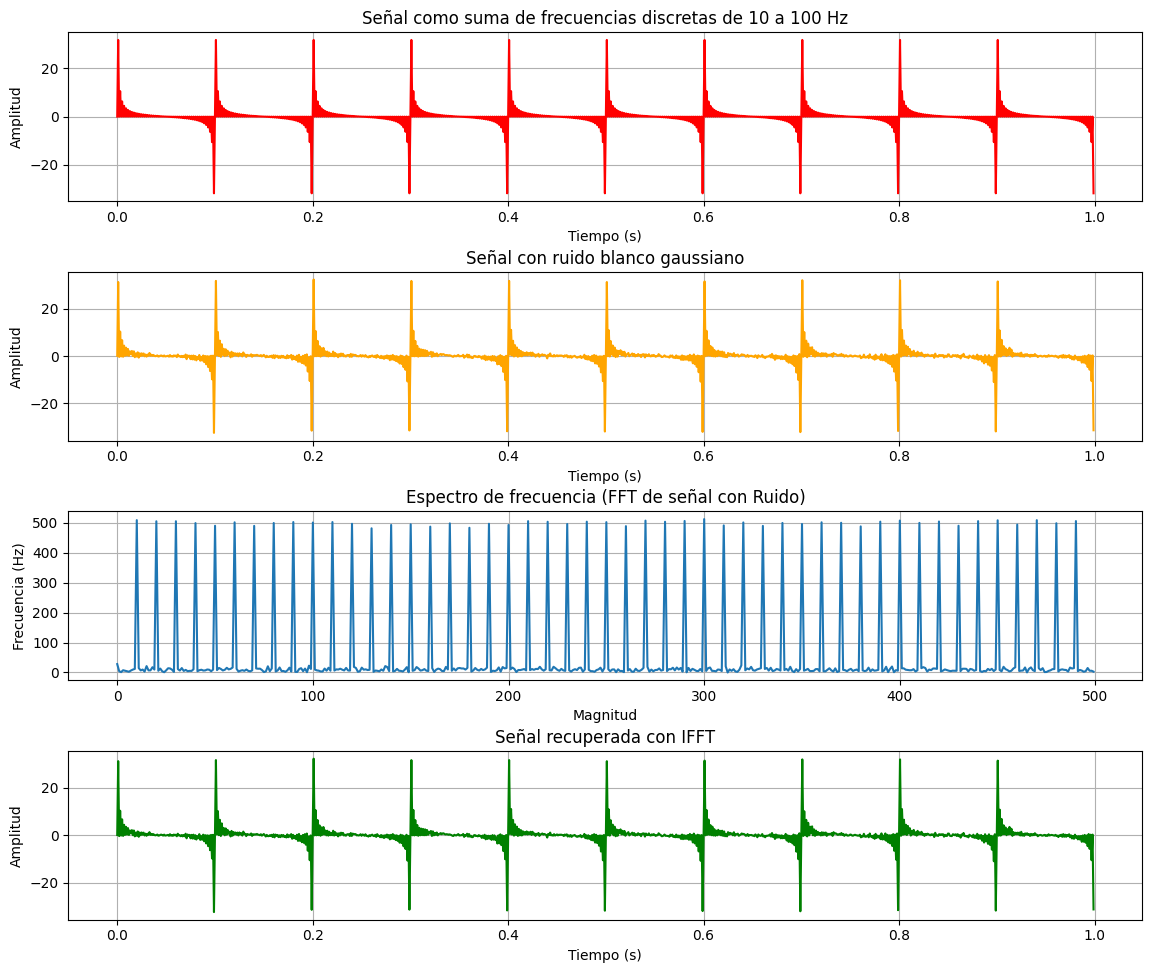

In [52]:
fs = 1000  # Frecuencia de muestreo (Hz)
t = 1
frequencies = np.arange(10, 501, 10)  # Frecuencias de 10 a 100 Hz en pasos de 10 Hz

# Crear la señal sumando componentes sinusoidales
# signal = np.sum([np.sin(2 * np.pi * f * t) for f in frequencies], axis=0)
# Utilizando dsp_utils
generator = SignalGenerator(frequency=frequencies, amplitude=1, duration=t, sampling_rate=fs )
time_vector = generator.time
signal = np.sum(generator.sine_wave, axis=0)

# Graficar la señal
fig, axs = plt.subplots(4, 1, figsize=(12, 10))
fig.tight_layout(pad=3.0)

axs[0].plot(time_vector, signal, color="red")
axs[0].set_title("Señal como suma de frecuencias discretas de 10 a 100 Hz" )
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Amplitud')
axs[0].grid(True)


noise = np.random.normal(0, 0.3, signal.shape)
noisy_signal = noise + signal


axs[1].plot(time_vector, noisy_signal, color="orange")
axs[1].set_title("Señal con ruido blanco gaussiano" )
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Amplitud')
axs[1].grid(True)


fft_result = np.fft.fft(noisy_signal)
fft_magnitude = np.abs(fft_result)
freq_fft = np.fft.fftfreq(len(time_vector), 1/fs)


axs[2].plot(freq_fft[:len(freq_fft)//2], fft_magnitude[:len(freq_fft)//2])
axs[2].set_title("Espectro de frecuencia (FFT de señal con Ruido)" )
axs[2].set_xlabel('Magnitud')
axs[2].set_ylabel('Frecuencia (Hz)')
axs[2].grid(True)


recovered_signal = np.fft.ifft(fft_result).real
axs[3].plot(time_vector, recovered_signal, color = "green")
axs[3].set_title("Señal recuperada con IFFT" )
axs[3].set_xlabel('Tiempo (s)')
axs[3].set_ylabel('Amplitud')
axs[3].grid(True)

**Filtrando señal**

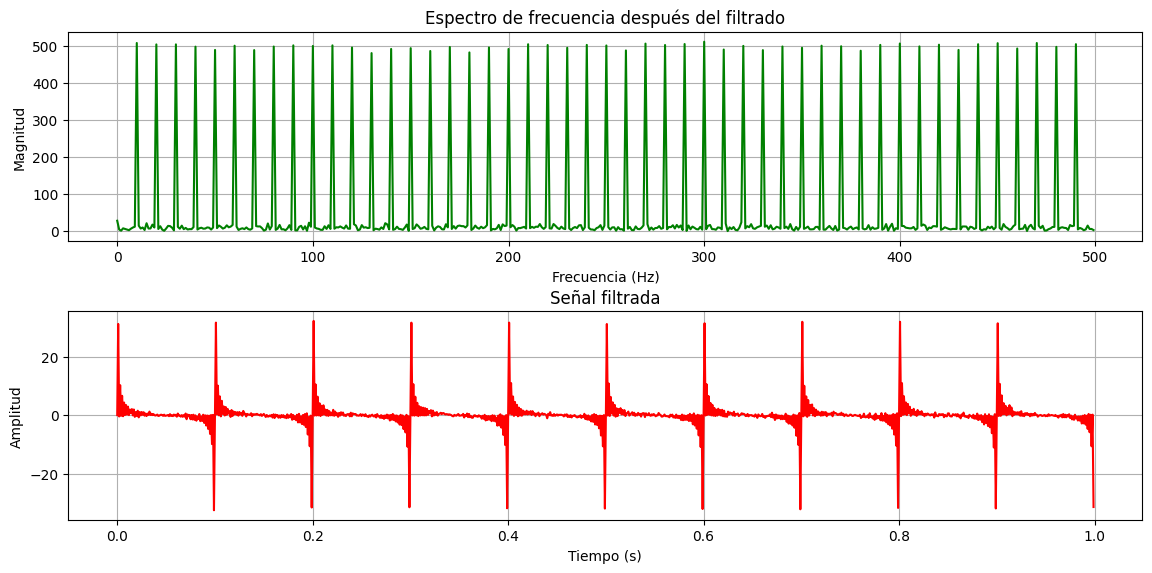

In [53]:
cutoff_freq = 500
fft_filtered = fft_result.copy()
fft_filtered[np.abs(freq_fft) > cutoff_freq] = 0


fig, axs = plt.subplots(2, 1, figsize=(12, 6))
fig.tight_layout(pad=3.0)

fft_magnitude_filtered = np.abs(fft_filtered)
axs[0].plot(freq_fft[:len(freq_fft)//2], fft_magnitude_filtered[:len(freq_fft)//2],color="green")
axs[0].set_title("Espectro de frecuencia después del filtrado")
axs[0].set_xlabel("Frecuencia (Hz)")
axs[0].set_ylabel("Magnitud")
axs[0].grid(True)


filtered_signal = np.fft.ifft(fft_filtered).real

axs[1].plot(time_vector, filtered_signal, color="red")
axs[1].set_title("Señal filtrada")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Amplitud")
axs[1].grid(True)



**Ecualizador de varias bandas**

In [54]:
def filter_(signal, f0, f1, sample_rate):
    f = flt.GenericButterBandPass(f0, f1, fs=sample_rate, N=2)
    signal_filtered = f(signal)
    return signal_filtered

In [92]:
@interact(
    fc1=(10, max(frequencies), 10),
    fc2=(10, max(frequencies), 10),
    fc3=(10, max(frequencies), 10),
    wb=(10, max(frequencies)/2, 10),
    gain=(-10, 10, 1)
)
def equalizer(fc1=50, fc2=250, fc3=400, wb=10, gain=0):
    fc = np.array([fc1, fc2, fc3])
    vis = Visualizer(figsize=(16, 7), dpi=100)
    signal_filtered = []

    for f in fc:
        f0 = f - wb
        f1 = f + wb
        sample_rate = generator.sampling_rate

        if f0 <= 0:
            f0 = 0.1
        if f1 >= sample_rate / 2:
            f1 = sample_rate / 2 - 0.1

        signal_filtered.append(filter_(signal, f0, f1, sample_rate))

    signal_filtered = sum(signal_filtered)
    signal_equalized = (signal - signal_filtered) + (signal_filtered * np.power(10, (gain / 20)))

    vis.plot_dsp(signal_equalized, sample_rate=1000, time=generator.time, ffn='vlines')
    plt.show()


interactive(children=(IntSlider(value=50, description='fc1', max=500, min=10, step=10), IntSlider(value=250, d…